# Phase Congruency–Guided Ridge Crack Detection


## 0) Setup + Imports

In [4]:
import os, glob, math
import numpy as np
import cv2
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy.fft import fft2, ifft2, fftshift
from skimage import exposure
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops

np.set_printoptions(precision=4, suppress=True)

def show(img, title="", cmap=None, figsize=(7,4)):
    plt.figure(figsize=figsize)
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

def overlay_mask(rgb, mask, alpha=0.45):
    # Overlay mask (red) onto rgb image.
    rgb2 = rgb.copy().astype(np.float32)
    m = (mask.astype(bool))[..., None]
    red = np.zeros_like(rgb2); red[...,0] = 255
    rgb2 = np.where(m, (1-alpha)*rgb2 + alpha*red, rgb2)
    return np.clip(rgb2, 0, 255).astype(np.uint8)



## 1) Load Image



CWD: d:\BK_251\Computer_Vision\Crack-detection
IMAGE_PATH: ./dataset/CrackForest-dataset-master\Image\001.jpg
GT_PATH   : ./dataset/CrackForest-dataset-master\groundtruthn_seg_masks\001.png


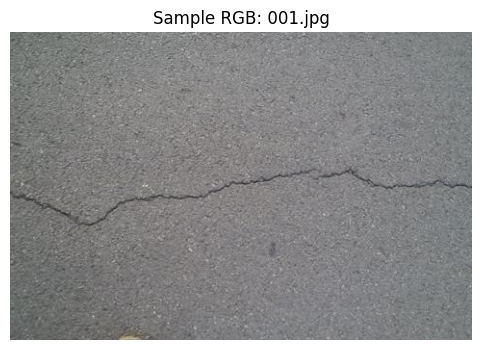

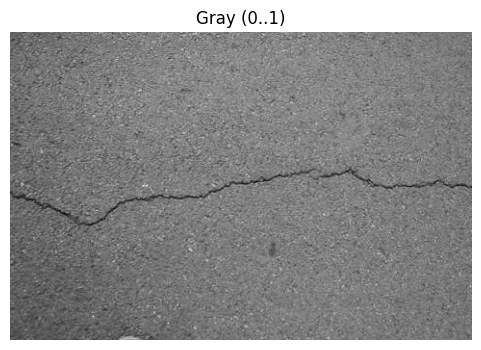

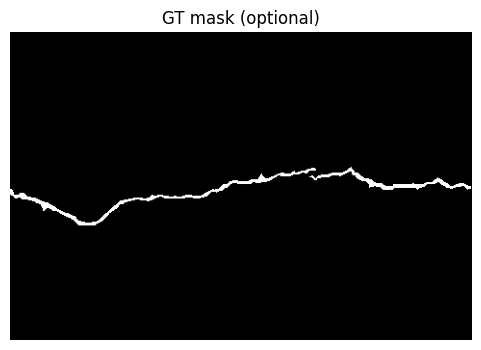

In [251]:
BASE = "./dataset/CrackForest-dataset-master" 
IMAGE_ID = "001" 
IMAGE_PATH = None  
GT_PATH = None     

def autodetect_paths(base, image_id):
    img_candidates = []
    for folder in ["image", "images", "Image", "Images"]:
        img_candidates += glob.glob(os.path.join(base, folder, f"{image_id}.*"))
    img_candidates = [p for p in img_candidates if os.path.splitext(p)[1].lower() in [".jpg",".jpeg",".png",".bmp",".tif",".tiff"]]
    img_candidates = sorted(img_candidates)

    gt_candidates = []
    for folder in ["groundtruth_seg_masks", "groundtruthn_seg_masks", "groundtruth", "mask", "masks"]:
        gt_candidates += glob.glob(os.path.join(base, folder, f"{image_id}.*"))
    gt_candidates += glob.glob(os.path.join(base, "groundtruth*_seg_masks", f"{image_id}.*"))
    gt_candidates = [p for p in gt_candidates if os.path.splitext(p)[1].lower() in [".png",".jpg",".jpeg",".bmp",".tif",".tiff"]]
    gt_candidates = sorted(gt_candidates)
    return (img_candidates[0] if img_candidates else None,
            gt_candidates[0] if gt_candidates else None)

if IMAGE_PATH is None:
    IMAGE_PATH, auto_gt = autodetect_paths(BASE, IMAGE_ID)
    if GT_PATH is None:
        GT_PATH = auto_gt

print("CWD:", os.getcwd())
print("IMAGE_PATH:", IMAGE_PATH)
print("GT_PATH   :", GT_PATH)

assert IMAGE_PATH is not None and os.path.isfile(IMAGE_PATH), f"Image not found: {IMAGE_PATH}"

bgr = cv2.imread(IMAGE_PATH, cv2.IMREAD_COLOR)
if bgr is None:
    raise RuntimeError(f"cv2.imread failed: {IMAGE_PATH}")

rgb  = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255.0

gt = None
if GT_PATH is not None and os.path.isfile(GT_PATH):
    gt_raw = cv2.imread(GT_PATH, cv2.IMREAD_GRAYSCALE)
    if gt_raw is not None:
        gt = (gt_raw > 0).astype(np.uint8)

show(rgb, f"Sample RGB: {os.path.basename(IMAGE_PATH)}")
show(gray, "Gray (0..1)", cmap="gray")
if gt is not None:
    show(gt, "GT mask (optional)", cmap="gray")


## 2) Preprocess (crack-friendly): illumination flatten + black-hat (dark thin lines)


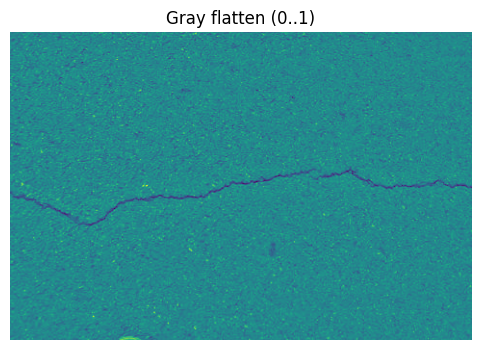

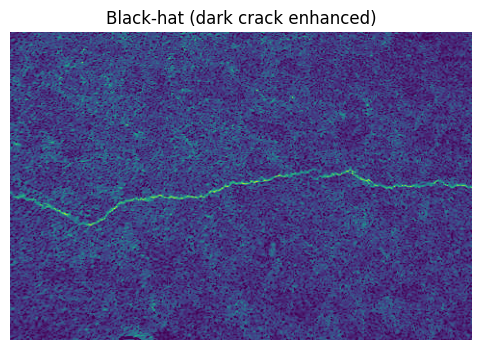

In [252]:
# ---- illumination flatten (high-pass) ----
# gray is float32 in [0,1]
blur_sigma = 12  # 8..20 (bigger = more flatten)
lowfreq = cv2.GaussianBlur(gray, (0,0), blur_sigma)
gray_flat = np.clip(gray - lowfreq + 0.5, 0, 1).astype(np.float32)

# ---- black-hat (enhance dark thin lines) ----
# Use uint8 for morphology stability
g8 = (gray_flat * 255).astype(np.uint8)
bh_ksize = 15  # 9..25 (bigger = enhance wider cracks; too big -> artifacts)
bh_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (bh_ksize, bh_ksize))
blackhat = cv2.morphologyEx(g8, cv2.MORPH_BLACKHAT, bh_kernel)
blackhat = (blackhat.astype(np.float32) / 255.0)

# Normalize helpers
def norm01(x):
    x = x.astype(np.float32)
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

gray_pc   = norm01(gray_flat)        # for phase congruency
gray_ridge = norm01(blackhat)        # for Hessian/ridge (dark-line prior)

show(gray_flat, "Gray flatten (0..1)")
show(blackhat, "Black-hat (dark crack enhanced)")


## 3) Phase Congruency (Kovesi-style, simplified)


In [253]:
def _lowpass_filter(shape, cutoff=0.45, sharpness=15):
    # Low-pass Butterworth-like.
    rows, cols = shape
    y = np.linspace(-0.5, 0.5, rows, endpoint=False)
    x = np.linspace(-0.5, 0.5, cols, endpoint=False)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X*X + Y*Y)
    filt = 1.0 / (1.0 + (radius / (cutoff + 1e-9))**(2*sharpness))
    return fftshift(filt)

def _log_gabor(shape, wavelength, sigmaOnf=0.55):
    rows, cols = shape
    y = np.linspace(-0.5, 0.5, rows, endpoint=False)
    x = np.linspace(-0.5, 0.5, cols, endpoint=False)
    X, Y = np.meshgrid(x, y)
    radius = np.sqrt(X*X + Y*Y)
    radius[rows//2, cols//2] = 1.0  # avoid log(0)
    fo = 1.0 / float(wavelength)
    logG = np.exp((-(np.log(radius/fo))**2) / (2*(np.log(sigmaOnf)**2)))
    logG[rows//2, cols//2] = 0.0
    return fftshift(logG)

def _angular_filter(shape, angle, thetaSigma=1.2):
    rows, cols = shape
    y = np.linspace(-0.5, 0.5, rows, endpoint=False)
    x = np.linspace(-0.5, 0.5, cols, endpoint=False)
    X, Y = np.meshgrid(x, y)
    theta = np.arctan2(-Y, X)  # image coords
    dtheta = np.angle(np.exp(1j*(theta - angle)))  # wrap [-pi, pi]
    ang = np.exp(-(dtheta*dtheta) / (2*thetaSigma*thetaSigma))
    return fftshift(ang)

def phase_congruency_2d(gray, nscale=4, norient=6, minWavelength=3.0, mult=2.1,
                       sigmaOnf=0.55, k=2.0, noiseMethod="median"):
    # Simplified Kovesi-like 2D Phase Congruency.
    # Returns: pc (0..1), orient (radians), totalEnergy, totalAn
    img = gray.astype(np.float32)
    rows, cols = img.shape
    IM = fft2(img)

    lp = _lowpass_filter(img.shape, cutoff=0.45, sharpness=15)
    eps = 1e-9

    totalEnergy = np.zeros_like(img, np.float32)
    totalAn = np.zeros_like(img, np.float32)

    sumE = np.zeros_like(img, np.float32)
    sumO = np.zeros_like(img, np.float32)

    for o in range(norient):
        angl = o * np.pi / norient
        angFilter = _angular_filter(img.shape, angl, thetaSigma=1.2)

        sumAn_or = np.zeros_like(img, np.float32)
        EOscales = []
        wavelength = float(minWavelength)

        for s in range(nscale):
            lg = _log_gabor(img.shape, wavelength, sigmaOnf=sigmaOnf)
            filt = lg * angFilter * lp
            conv = ifft2(IM * filt)
            E = np.real(conv).astype(np.float32)
            O = np.imag(conv).astype(np.float32)
            An = np.sqrt(E*E + O*O).astype(np.float32)

            sumAn_or += An
            EOscales.append((E, O, An))
            wavelength *= mult

        # Noise threshold (simplified) using smallest scale amplitude
        An1 = EOscales[0][2]
        if noiseMethod == "median":
            tau = np.median(An1) / np.sqrt(np.log(4.0))
            estNoise = tau * np.sqrt(np.pi/2.0)
        else:
            estNoise = np.mean(An1)
        T = estNoise * float(k)

        # Energy proxy: sum of amplitudes across scales, thresholded
        energy = sum([An for (_,_,An) in EOscales]).astype(np.float32)
        energy = np.maximum(energy - T, 0)

        totalEnergy += energy
        totalAn += sumAn_or

        # orientation vector (weighted)
        sumE += energy * np.cos(angl)
        sumO += energy * np.sin(angl)

    pc = totalEnergy / (totalAn + eps)
    pc = np.clip(pc, 0, 1).astype(np.float32)

    orient = np.arctan2(sumO, sumE).astype(np.float32)
    orient = ((orient + np.pi/2) % np.pi) - np.pi/2
    return pc, orient, totalEnergy, totalAn


### (Optional) Use `phasepack` (Kovesi) if available


In [255]:
USE_PHASEPACK = False
try:
    from phasepack import phasecong
    USE_PHASEPACK = True
    print("✅ phasepack available: will use Kovesi phasecong()")
except Exception as e:
    print("ℹ️ phasepack not found -> fallback to simplified phase_congruency_2d().")
    USE_PHASEPACK = False

def compute_pc(gray01, nscale=4, norient=6, minWavelength=3.0, mult=2.1, sigmaOnf=0.55, k=2.0, cutOff=0.5, g=10):
    if USE_PHASEPACK:
        out = phasecong(
            gray01, nscale=nscale, norient=norient,
            minWaveLength=minWavelength, mult=mult,
            sigmaOnf=sigmaOnf, k=k, cutOff=cutOff, g=g
        )
        pc = out[0]
        orient = out[1]
        pc = np.clip(pc, 0, 1).astype(np.float32)
        orient = (orient % np.pi).astype(np.float32)
        return pc, orient



✅ phasepack available: will use Kovesi phasecong()


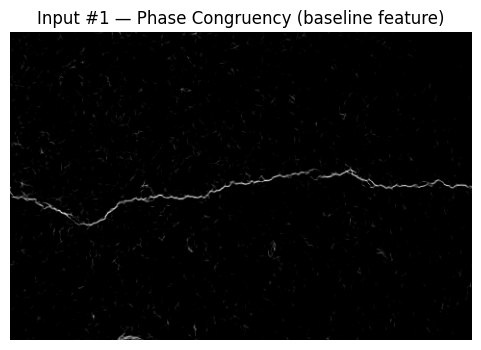

In [256]:
pc1, orient1 = compute_pc(
    gray_pc, nscale=4, norient=6, minWavelength=3.0, mult=2.1, sigmaOnf=0.55, k=2.0, cutOff=0.5, g=10
)

show(pc1, "Input #1 — Phase Congruency (baseline feature)", cmap="gray")


## 4) Multi-scale / multi-orientation tuning (crack-friendly)


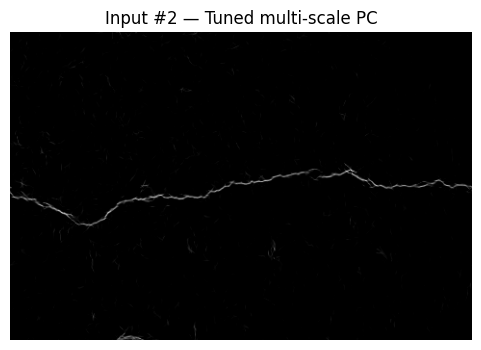

In [257]:
pc2, orient2 = compute_pc(
    gray_pc, nscale=5, norient=8, minWavelength=3.0, mult=2.0, sigmaOnf=0.55, k=2.5
)
show(pc2, "Input #2 — Tuned multi-scale PC", cmap="gray")


## 5) Orientation Coherence (decrease texture)


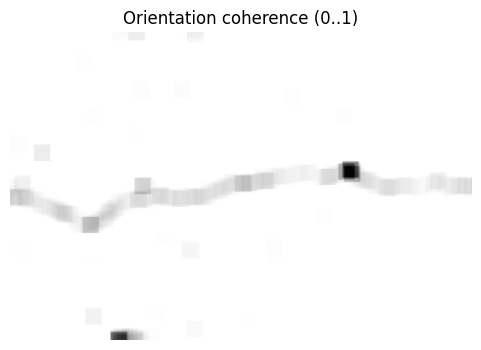

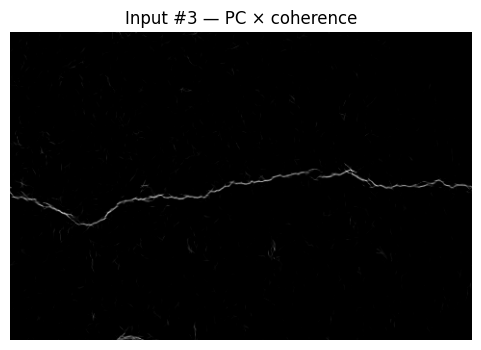

In [258]:
def orientation_coherence(theta, win=15):
    z = np.exp(1j * 2.0 * theta)
    real = ndi.uniform_filter(np.real(z), size=win)
    imag = ndi.uniform_filter(np.imag(z), size=win)
    coh = np.sqrt(real*real + imag*imag)
    return np.clip(coh, 0, 1).astype(np.float32)

coh2 = orientation_coherence(orient2, win=17)
pc3 = pc2 * (0.35 + 0.65*coh2)
pc3 = np.clip(pc3, 0, 1)

show(coh2, "Orientation coherence (0..1)", cmap="gray")
show(pc3, "Input #3 — PC × coherence", cmap="gray")


## 6) Hessian eigenvalues → Ridge magnitude


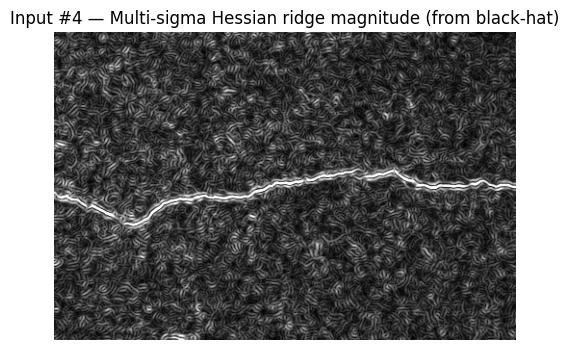

In [259]:
def hessian_eigs(gray, sigma=2.0):
    I = gray.astype(np.float32)
    I = ndi.gaussian_filter(I, sigma=sigma)
    Ixx = ndi.gaussian_filter(I, sigma=sigma, order=(2,0))
    Iyy = ndi.gaussian_filter(I, sigma=sigma, order=(0,2))
    Ixy = ndi.gaussian_filter(I, sigma=sigma, order=(1,1))

    tmp = np.sqrt((Ixx - Iyy)**2 + 4.0*(Ixy**2))
    l1 = 0.5*(Ixx + Iyy + tmp)
    l2 = 0.5*(Ixx + Iyy - tmp)

    swap = np.abs(l1) < np.abs(l2)
    l1s = l1.copy(); l2s = l2.copy()
    l1s[swap], l2s[swap] = l2[swap], l1[swap]
    return l1s.astype(np.float32), l2s.astype(np.float32)

# ---- Multi-sigma ridge fusion (stronger & more stable) ----
ridge_sigmas = [1.2, 2.0, 3.0]   # tune: [1.0..4.0]
l1_list, l2_list, mag_list = [], [], []
for s in ridge_sigmas:
    l1_s, l2_s = hessian_eigs(gray_ridge, sigma=s)  # use black-hat enhanced image
    mag = np.abs(l1_s)
    # robust clip to suppress rare spikes
    mag = np.clip(mag, 0, np.percentile(mag, 99.5))
    mag_list.append(mag)

ridge_mag = np.max(np.stack(mag_list, axis=0), axis=0).astype(np.float32)
ridge_mag = ridge_mag / (ridge_mag.max() + 1e-9)

# keep eigenvalues from the *best* scale per pixel (for anisotropy)
best_idx = np.argmax(np.stack(mag_list, axis=0), axis=0)
# pick l1,l2 per-pixel
l1 = np.zeros_like(ridge_mag, np.float32)
l2 = np.zeros_like(ridge_mag, np.float32)
for i, s in enumerate(ridge_sigmas):
    l1_s, l2_s = hessian_eigs(gray_ridge, sigma=s)
    sel = (best_idx == i)
    l1[sel] = l1_s[sel]
    l2[sel] = l2_s[sel]

show(ridge_mag, "Input #4 — Multi-sigma Hessian ridge magnitude (from black-hat)", cmap="gray")


## 7) Combine: (PC×coh) × ridge magnitude


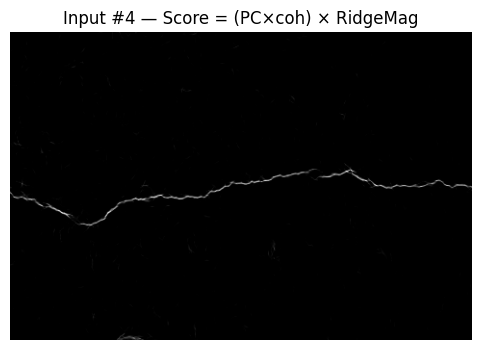

In [260]:
score1 = pc3 * ridge_mag
score1 = score1 / (score1.max() + 1e-9)
show(score1, "Input #4 — Score = (PC×coh) × RidgeMag", cmap="gray")


## 8) Anisotropy filter (omit blob/texture)

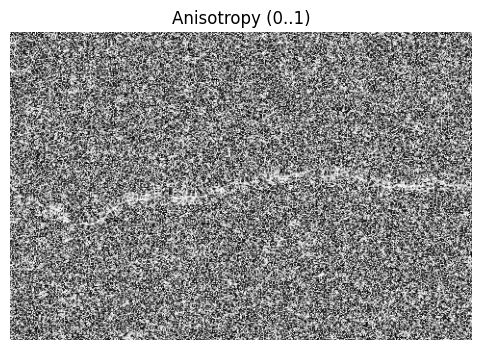

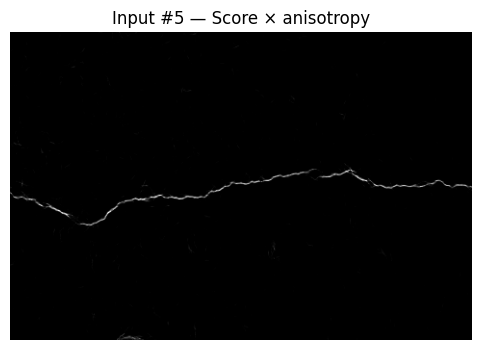

In [261]:
anis = (np.abs(l1) - np.abs(l2)) / (np.abs(l1) + np.abs(l2) + 1e-9)
anis = np.clip(anis, 0, 1).astype(np.float32)

score2 = score1 * (0.3 + 0.7*anis)
score2 = score2 / (score2.max() + 1e-9)

show(anis, "Anisotropy (0..1)", cmap="gray")
show(score2, "Input #5 — Score × anisotropy", cmap="gray")


## 9) Adaptive threshold (percentile) → Darkness prior (crack = dark line)


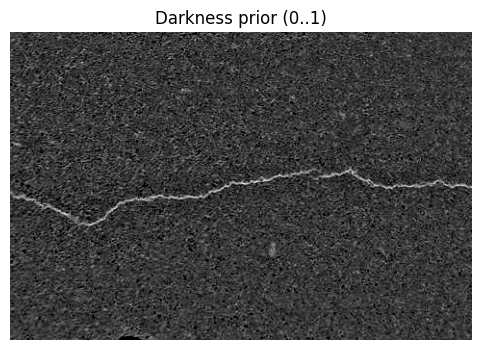

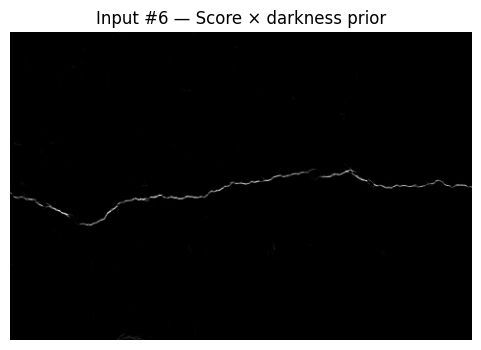

In [263]:
# darkness in [0,1] (higher = darker)
dark = np.clip(0.6 - gray_flat, 0, 1).astype(np.float32)
dark = dark / (dark.max() + 1e-9)

score3 = score2 * (0.35 + 0.65*dark)
score3 = score3 / (score3.max() + 1e-9)

show(dark, "Darkness prior (0..1)", cmap="gray")
show(score3, "Input #6 — Score × darkness prior", cmap="gray")


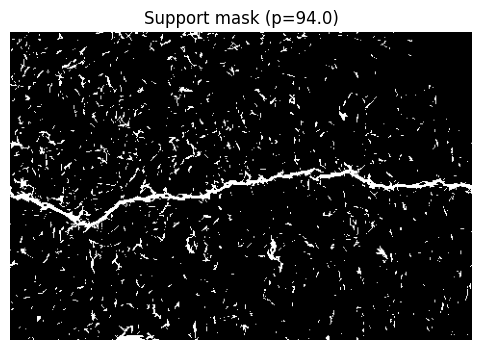

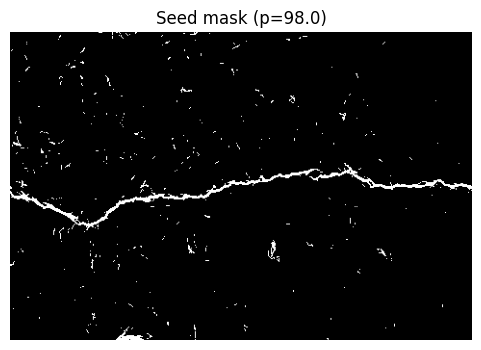

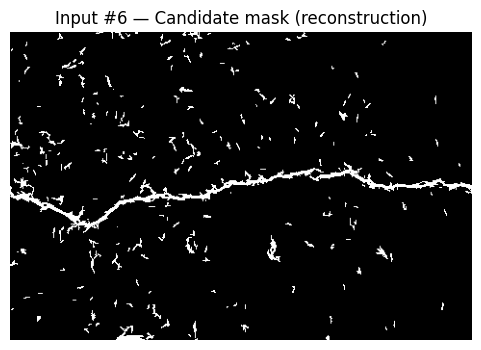

In [264]:
def recon_by_dilation(seed, support, max_iters=400):
    seed = seed.astype(np.uint8)
    support = support.astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    prev = seed.copy()
    for _ in range(max_iters):
        dil = cv2.dilate(prev, k, iterations=1)
        nxt = (dil & support)
        if np.array_equal(nxt, prev):
            break
        prev = nxt
    return prev.astype(bool)

# tune (start points for CrackForest)
p_low  = 94.0   # support percentile (94..97)
p_high = 98.0 # seed percentile    (98.5..99.7)

th_low  = np.percentile(score3, p_low)
th_high = np.percentile(score3, p_high)

support = (score3 >= th_low)
seed    = (score3 >= th_high)

mask1 = recon_by_dilation(seed, support)

show(support.astype(np.uint8)*255, f"Support mask (p={p_low})", cmap="gray")
show(seed.astype(np.uint8)*255,    f"Seed mask (p={p_high})", cmap="gray")
show(mask1.astype(np.uint8)*255,   "Input #6 — Candidate mask (reconstruction)", cmap="gray")

## 10) Direction-aware connectivity (orientation-consistent)

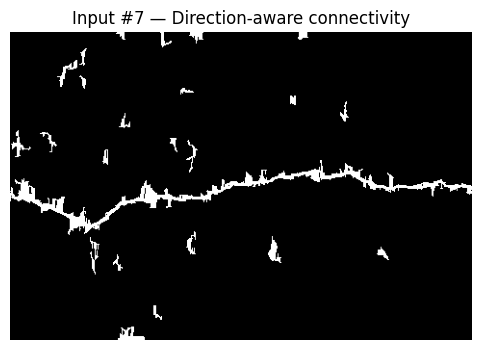

In [265]:
def line_kernel(length=9, angle_deg=0.0):
    k = np.zeros((length, length), np.uint8)
    c = length//2
    a = np.deg2rad(angle_deg)
    x0 = int(c - c*np.cos(a)); y0 = int(c - c*np.sin(a))
    x1 = int(c + c*np.cos(a)); y1 = int(c + c*np.sin(a))
    cv2.line(k, (x0,y0), (x1,y1), 1, 1)
    return k

def direction_aware_close(mask, orient, bins=12, length=13):
    out = np.zeros_like(mask, dtype=bool)
    theta = (orient + np.pi/2) % np.pi
    edges = np.linspace(0, np.pi, bins+1)
    for i in range(bins):
        t0, t1 = edges[i], edges[i+1]
        sel = (theta >= t0) & (theta < t1) & mask
        if sel.sum() == 0:
            continue
        ang_deg = np.rad2deg(0.5*(t0+t1))
        k = line_kernel(length=length, angle_deg=ang_deg)
        sel_u8 = (sel.astype(np.uint8)*255)
        closed = cv2.morphologyEx(sel_u8, cv2.MORPH_CLOSE, k)
        out |= (closed > 0)
    return out

mask2 = direction_aware_close(mask1, orient2, bins=12, length=13)
mask2 = remove_small_objects(mask2, min_size=40)

show(mask2.astype(np.uint8)*255, "Input #7 — Direction-aware connectivity", cmap="gray")


## 11) Skeletonize + prune short components


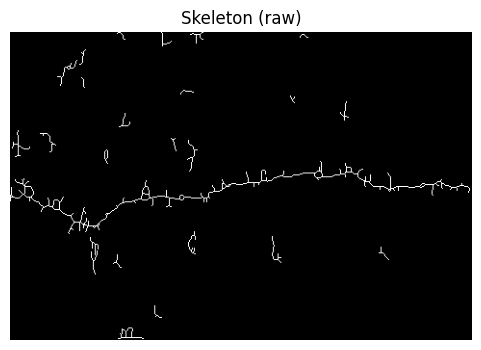

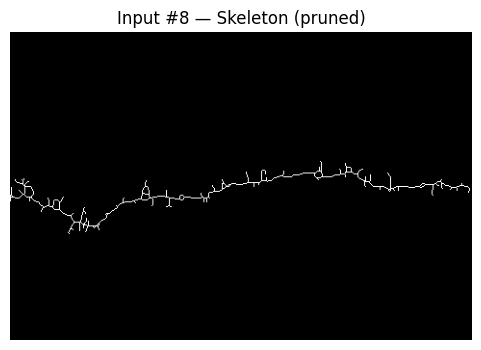

In [266]:
skel = skeletonize(mask2)

def prune_by_size(binary, min_pixels=70):
    lab = label(binary, connectivity=2)
    out = np.zeros_like(binary, dtype=bool)
    for r in regionprops(lab):
        if r.area >= min_pixels:
            out[lab == r.label] = True
    return out

skel_p = prune_by_size(skel, min_pixels=70)

show(skel.astype(np.uint8)*255, "Skeleton (raw)", cmap="gray")
show(skel_p.astype(np.uint8)*255, "Input #8 — Skeleton (pruned)", cmap="gray")


## 12) Oriented gap bridging (controlled)


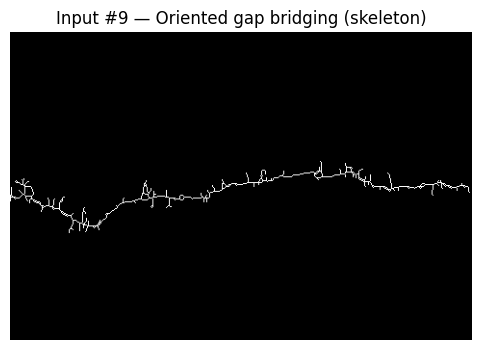

In [267]:
def oriented_bridge(skel, orient, support_mask, bins=12, length=19):
    theta = (orient + np.pi/2) % np.pi
    out = np.zeros_like(skel, dtype=bool)
    edges = np.linspace(0, np.pi, bins+1)
    for i in range(bins):
        t0, t1 = edges[i], edges[i+1]
        sel = (theta >= t0) & (theta < t1) & skel
        if sel.sum() == 0:
            continue
        ang_deg = np.rad2deg(0.5*(t0+t1))
        k = line_kernel(length=length, angle_deg=ang_deg)
        sel_u8 = sel.astype(np.uint8)*255
        dil = cv2.dilate(sel_u8, k, iterations=1) > 0
        out |= dil
    out = out & support_mask
    out = skeletonize(out)
    out = prune_by_size(out, min_pixels=70)
    return out

final_skel = oriented_bridge(skel_p, orient2, mask2, bins=12, length=19)
show(final_skel.astype(np.uint8)*255, "Input #9 — Oriented gap bridging (skeleton)", cmap="gray")


## 13) Final mask + overlay + metrics


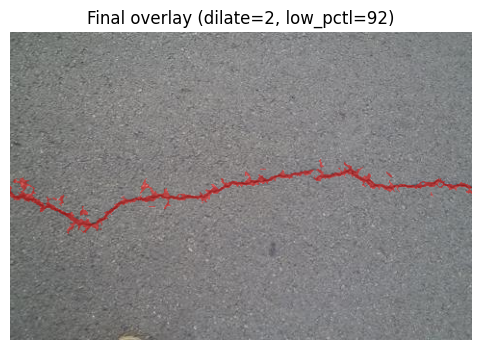

In [268]:
pred_dilate_px = 2     # 1..3
low_pctl = 92          # support mềm (90..95), giúp giới hạn vùng
smooth_open = 1        # 0..1 (opening nhẹ)

# support mềm từ score (giữ crack, giới hạn ăn lan)
low_th = np.percentile(score3, low_pctl)
support = (score3 >= low_th)

# thicken skeleton
k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*pred_dilate_px+1, 2*pred_dilate_px+1))
thick = cv2.dilate((final_skel.astype(np.uint8)*255), k, iterations=1) > 0

# cắt lại theo support để không “phình” vào nền
final_mask = thick & support

# làm mượt biên (optional)
if smooth_open > 0:
    k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2*smooth_open+1, 2*smooth_open+1))
    k3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    final_mask = cv2.morphologyEx(final_mask.astype(np.uint8)*255, cv2.MORPH_CLOSE, k3) > 0

show(overlay_mask(rgb, final_mask), f"Final overlay (dilate={pred_dilate_px}, low_pctl={low_pctl})", cmap=None)



## 13) Summary grid


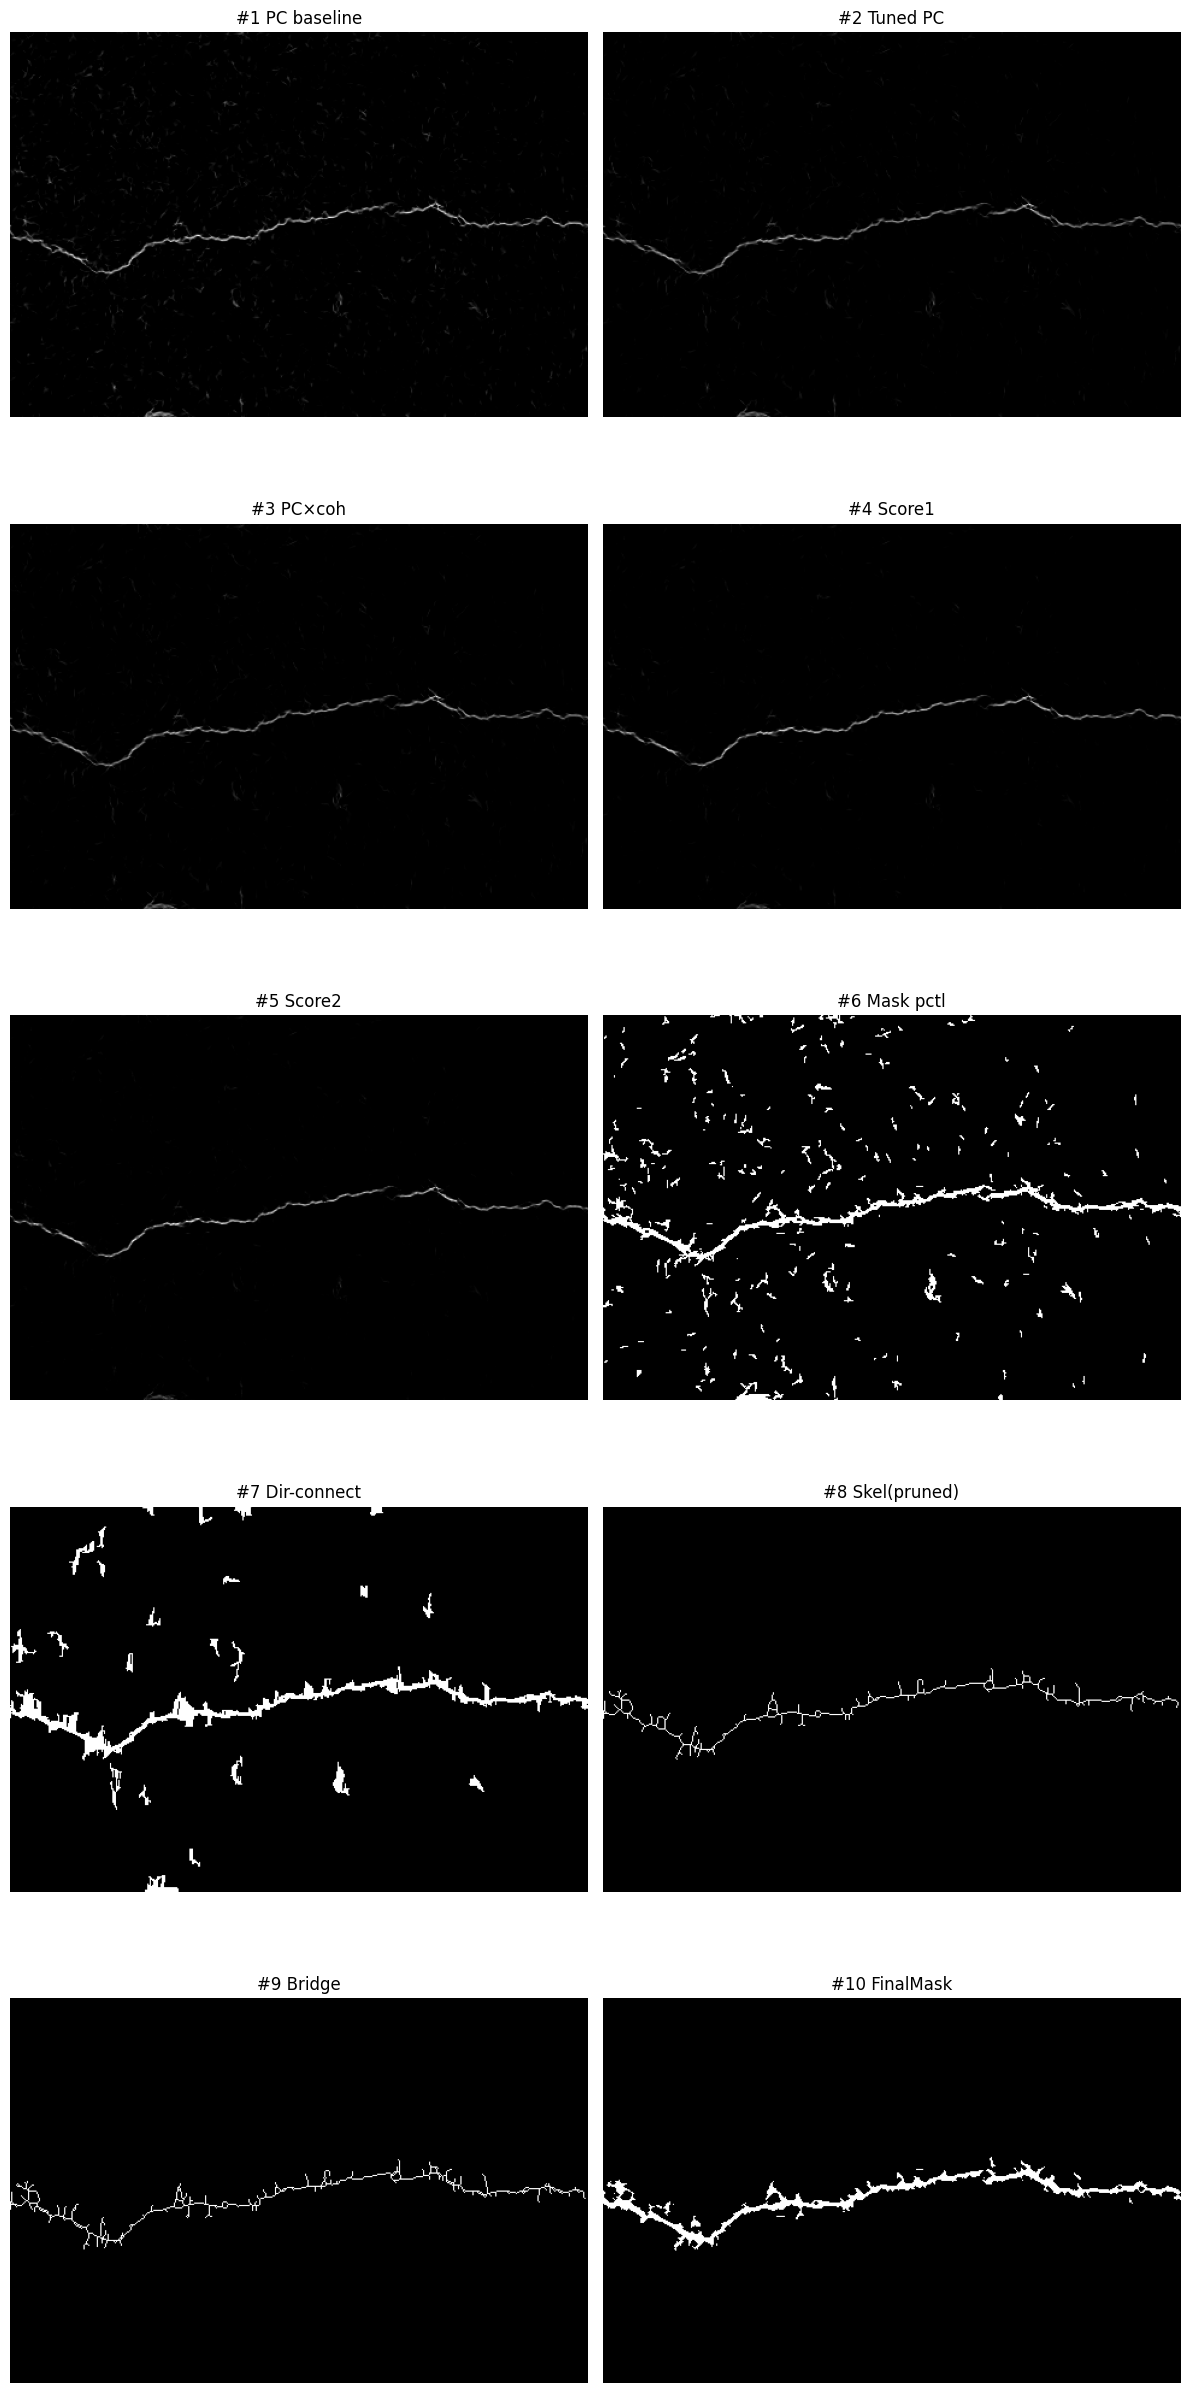

In [269]:
stages = [
    ("#1 PC baseline", pc1),
    ("#2 Tuned PC", pc2),
    ("#3 PC×coh", pc3),
    ("#4 Score1", score1),
    ("#5 Score2", score2),
    ("#6 Mask pctl", mask1.astype(np.float32)),
    ("#7 Dir-connect", mask2.astype(np.float32)),
    ("#8 Skel(pruned)", skel_p.astype(np.float32)),
    ("#9 Bridge", final_skel.astype(np.float32)),
    ("#10 FinalMask", final_mask.astype(np.float32)),
]

cols = 2
rows = math.ceil(len(stages)/cols)
plt.figure(figsize=(12, 5*rows))
for i,(name,img) in enumerate(stages,1):
    plt.subplot(rows, cols, i)
    plt.imshow(img, cmap="gray")
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()
